 # GA for VRP Encoding

In [1]:
import os, random, time, math
from dataclasses import dataclass
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Config / Seeding
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)


In [3]:
# Data model
@dataclass
class VRPInstance:
    name: str
    depot: Tuple[float, float]
    customers: List[Tuple[float, float]]  # [(x,y), ...]
    vehicles: int


In [4]:
# Load customers (CSV with: id,x,y)
def load_customers_df():
    for p in ["/content/customers.csv", "/mnt/data/customers.csv", "data/customers.csv"]:
        if os.path.exists(p):
            return pd.read_csv(p), p
    raise FileNotFoundError("customers.csv not found. Place it at /content/, /mnt/data/, or data/")

df, CSV_PATH = load_customers_df()

n_customers = random.randint(15, 30)
sample = df.sample(n=n_customers, random_state=RANDOM_SEED).sort_values("id")
customers_xy = list(zip(sample["x"].values, sample["y"].values))

print(f"Loaded {CSV_PATH}")
print(f"Picked IDs: {sample['id'].tolist()}")


Loaded /content/customers.csv
Picked IDs: [4, 5, 7, 9, 13, 14, 18, 20, 26, 27, 31, 33, 38, 40, 42, 46, 47, 49]


In [5]:
# Build two medium instances that share the same customers but differ in vehicles
n_customers = len(customers_xy)

# M1: try to make vehicles > customers, but cap at 25
if n_customers <= 24:
    vehicles_M1 = random.randint(n_customers + 1, 25)
else:
    vehicles_M1 = 25  # best we can do under the 25-cap

upper_M2 = min(25, max(11, n_customers - 1))
vehicles_M2 = random.randint(11, upper_M2)

# Ensure M1 and M2 differ
while vehicles_M2 == vehicles_M1:
    vehicles_M2 = random.randint(11, upper_M2)


M1 = VRPInstance(
    name="Medium – Instance 1",
    depot=(50.0, 50.0),
    customers=customers_xy,
    vehicles=vehicles_M1
)
M2 = VRPInstance(
    name="Medium – Instance 2",
    depot=(50.0, 50.0),
    customers=customers_xy,
    vehicles=vehicles_M2
)

instances = [M1, M2]

print(f"M1 -> vehicles={M1.vehicles}, customers={len(M1.customers)}")
print(f"M2 -> vehicles={M2.vehicles}, customers={len(M2.customers)}")

M1 -> vehicles=19, customers=18
M2 -> vehicles=16, customers=18


In [6]:

# Distances
def distance_matrix(coords: List[Tuple[float, float]]) -> np.ndarray:
    n = len(coords)
    D = np.zeros((n, n), dtype=float)
    for i in range(n):
        xi, yi = coords[i]
        for j in range(i+1, n):
            xj, yj = coords[j]
            d = math.hypot(xi - xj, yi - yj)
            D[i, j] = d
            D[j, i] = d
    return D

def build_D(inst: VRPInstance) -> np.ndarray:
    return distance_matrix([inst.depot] + inst.customers)


In [7]:
def genetic_algorithm(D: np.ndarray,
                      k: int,
                      n_customers: int,
                      params: dict,
                      seed: int = 0,
                      max_seconds: float = None) -> dict:
    """
    Chromosome: permutation of 1..n (0 is depot in D)
    Fitness styles (params['fitness_style']):
      - 'min': minimize total distance (default)
      - 'max_inverse': maximize 1 / total distance
    """
    # --- seeding ---
    rnd_state = random.getstate()
    np_state  = np.random.get_state()
    random.seed(seed); np.random.seed(seed)

    pop_size = params.get("pop", 80)
    gens     = params.get("gens", 200)
    pc       = params.get("pc", 0.90)
    pm       = params.get("pm", 0.05)
    tsize    = params.get("tsize", 3)
    fitness_style = params.get("fitness_style", "min")  # <-- NEW

    base = list(range(1, n_customers+1))
    pop  = [random.sample(base, n_customers) for _ in range(pop_size)]

    # Compute total distance for a permutation (Finner korteste rute)
    def total_distance_from_perm(perm: List[int]) -> float:
        n = len(perm)
        base_sz, rem = n // k, n % k
        total, idx = 0.0, 0
        for i in range(k):
            size  = base_sz + (1 if i < rem else 0)
            route = perm[idx: idx+size]
            idx  += size
            if not route:
                continue
            total += D[0, route[0]]
            for j in range(len(route)-1):
                total += D[route[j], route[j+1]]
            total += D[route[-1], 0]
        return total

    # # Not Split (doesnt work)
    # def total_distance_from_routes(routes: List[List[int]], D: np.ndarray) -> float:
    #     total = 0.0
    #     for r in routes:
    #         if not r:
    #             continue
    #         # If depot is already included (0 ... 0), sum along the path directly
    #         if r[0] == 0 and r[-1] == 0:
    #             for i in range(len(r) - 1):
    #                 total += D[r[i], r[i+1]]
    #         else:
    #             # Otherwise, assume r lists only customers; add depot legs
    #             total += D[0, r[0]]
    #             for i in range(len(r) - 1):
    #                 total += D[r[i], r[i+1]]
    #             total += D[r[-1], 0]
    #     return total


    # Fitness wrapper: choose style
    if fitness_style == "max_inverse":
        # larger is better
        def fitness(ind):
            dist = total_distance_from_perm(ind)
            return (1.0 / dist) if dist > 0 else float("inf")
        # tournament/elitism pick max
        def pick_best_id(fvals): return max(range(len(fvals)), key=lambda i: fvals[i])
        def better(a, b): return a > b
    else:
        # default: minimize distance (smaller is better)
        def fitness(ind):
            return total_distance_from_perm(ind)
        # tournament/elitism pick min
        def pick_best_id(fvals): return min(range(len(fvals)), key=lambda i: fvals[i])
        def better(a, b): return a < b

    # --- evaluate init pop ---
    fits = [fitness(ind) for ind in pop]
    best_idx  = pick_best_id(fits)
    best_perm = pop[best_idx][:]
    best_fit  = fits[best_idx]

    start = time.time()
    for _ in range(gens):
        new_pop = [best_perm[:]]  # elitism

        while len(new_pop) < pop_size:
            # tournament selection (consistent with style via pick_best_id on a sampled subset)
            cand = random.sample(range(len(pop)), tsize)
            p1 = pop[pick_best_id([fits[i] for i in cand])]
            cand = random.sample(range(len(pop)), tsize)
            p2 = pop[pick_best_id([fits[i] for i in cand])]

            # OX crossover
            a, b = sorted(random.sample(range(n_customers), 2))
            if random.random() < pc:
                c1 = [None]*n_customers; c1[a:b+1] = p1[a:b+1]
                fill = [x for x in p2 if x not in c1]
                idxs = list(range(0,a)) + list(range(b+1,n_customers))
                for idx, v in zip(idxs, fill): c1[idx] = v

                c2 = [None]*n_customers; c2[a:b+1] = p2[a:b+1]
                fill = [x for x in p1 if x not in c2]
                idxs = list(range(0,a)) + list(range(b+1,n_customers))
                for idx, v in zip(idxs, fill): c2[idx] = v
            else:
                c1, c2 = p1[:], p2[:]

            # swap mutation
            def mutate(ind: List[int]) -> List[int]:
                ind = ind[:]
                for i in range(len(ind)):
                    if random.random() < pm:
                        j = random.randrange(len(ind))
                        ind[i], ind[j] = ind[j], ind[i]
                return ind

            c1, c2 = mutate(c1), mutate(c2)
            if len(new_pop) < pop_size: new_pop.append(c1)
            if len(new_pop) < pop_size: new_pop.append(c2)

        pop  = new_pop
        fits = [fitness(ind) for ind in pop]

        gi = pick_best_id(fits)
        if better(fits[gi], best_fit):
            best_fit, best_perm = fits[gi], pop[gi][:]

        if max_seconds and (time.time() - start > max_seconds):
            break

    runtime = time.time() - start

    # restore RNG
    random.setstate(rnd_state)
    np.random.set_state(np_state)

    # For reporting, always return the actual distance
    best_distance = total_distance_from_perm(best_perm)
    return {
        "best_distance": best_distance,
        "best_perm": best_perm,
        "fitness_value": best_fit,
        "fitness_style": fitness_style,
        "runtime_sec": runtime
    }


In [8]:

## Decode permutation into routes (for printing/plotting)
def decode_routes_even(perm: List[int], k: int) -> List[List[int]]:
    n = len(perm)
    base, rem = n // k, n % k
    routes, idx = [], 0
    for i in range(k):
        size = base + (1 if i < rem else 0)
        r = perm[idx: idx+size]
        idx += size
        routes.append(r)
    return routes


In [9]:

# Plot
def plot_solution(inst: VRPInstance, routes: List[List[int]], title="VRP"):
    depot = inst.depot
    pts   = inst.customers
    plt.figure(figsize=(6,6))
    plt.grid(True, alpha=0.3)
    plt.gca().set_aspect("equal", adjustable="box")

    # depot
    plt.scatter([depot[0]],[depot[1]], marker="s", s=120, edgecolors="k", linewidths=1.2, zorder=4, label="Depot")

    # customers
    xs, ys = zip(*pts)
    plt.scatter(xs, ys, s=25, c="#777777", zorder=2)

    # draw routes
    for r in routes:
        if not r:
            continue
        path = [depot] + [pts[i-1] for i in r] + [depot]
        x, y = zip(*path)
        plt.plot(x, y, "-", lw=2, alpha=0.9)
        plt.scatter(x[1:-1], y[1:-1], s=40, edgecolors="k", linewidths=0.6, zorder=5)

    plt.title(f"{title}\n{inst.name} — customers={len(inst.customers)}, vehicles={inst.vehicles}")
    plt.xlabel("x"); plt.ylabel("y")
    plt.show()


In [10]:

# Run
param_sets = {
    "Param Set A": {"pop": 80,  "gens": 200, "pc": 0.90, "pm": 0.05, "tsize": 3},
    "Param Set B": {"pop": 160, "gens": 400, "pc": 0.90, "pm": 0.02, "tsize": 3},
    "Param Set C": {"pop": 240, "gens": 600, "pc": 0.95, "pm": 0.02, "tsize": 3},
}

records = []
for inst in instances:
    D = build_D(inst)
    n_cust = len(inst.customers)
    for pname, p in param_sets.items():
        times, dists = [], []
        for s in range(10):
            res = genetic_algorithm(D, inst.vehicles, n_cust, p, seed=s)
            times.append(res["runtime_sec"])
            dists.append(res["best_distance"])
        records.append({
            "Instance": inst.name,
            "Customers": n_cust,
            "Vehicles": inst.vehicles,
            "Param Set": pname,
            "Best Dist": min(dists),
            "Avg Dist":  float(np.mean(dists)),
            "Worst Dist": max(dists),
            "Avg Time":  float(np.mean(times)),
        })

df = pd.DataFrame(records)
display(df)



,Instance,Customers,Vehicles,Param Set,Best Dist,Avg Dist,Worst Dist,Avg Time
0,Medium – Instance 1,18,19,Param Set A,1474.683545,1474.683545,1474.683545,1.112260
1,Medium – Instance 1,18,19,Param Set B,1474.683545,1474.683545,1474.683545,2.428782
2,Medium – Instance 1,18,19,Param Set C,1474.683545,1474.683545,1474.683545,4.858928
3,Medium – Instance 2,18,16,Param Set A,1283.922566,1283.922566,1283.922566,0.490953
4,Medium – Instance 2,18,16,Param Set B,1283.922566,1287.056035,1305.466129,1.971989
5,Medium – Instance 2,18,16,Param Set C,1283.922566,1283.922566,1283.922566,4.229794


Best config: {'Instance': 'Medium – Instance 2', 'Customers': 18, 'Vehicles': 16, 'Param Set': 'Param Set A', 'Best Dist': 1283.9225661235917, 'Avg Dist': 1283.9225661235919, 'Worst Dist': 1283.9225661235919, 'Avg Time': 0.49095337390899657}
Best distance: 1283.92, time: 0.457s


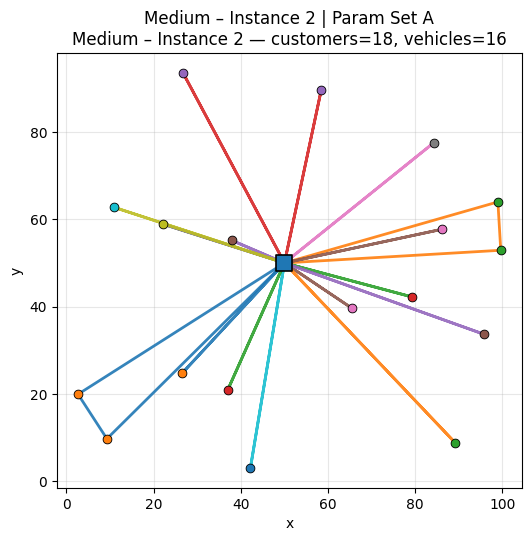

In [11]:


# Best row and run once for plotting
best_row = df.sort_values("Avg Dist", ascending=True).iloc[0]
print("Best config:", best_row.to_dict())

best_inst = next(x for x in instances if x.name == best_row["Instance"])
best_params = param_sets[best_row["Param Set"]]

D_best = build_D(best_inst)
res = genetic_algorithm(D_best, best_inst.vehicles, len(best_inst.customers), best_params, seed=RANDOM_SEED)
routes = decode_routes_even(res["best_perm"], best_inst.vehicles)

print(f"Best distance: {res['best_distance']:.2f}, time: {res['runtime_sec']:.3f}s")
plot_solution(best_inst, routes, title=f"{best_inst.name} | {best_row['Param Set']}")
